### What is & Why JAX?
- 可运行于GPU/TPU上的高性能数值计算库(可替代Numpy)
- 使用函数进行自动微分计算和反向传播(可正向传, 可反向传, 支持多种微分操作)
- 谷歌Brain开发(2018), DeepMind使用(2020)

##### 优点
- 随时生成优化的计算图: 极其灵活, 容易上手, 可移植性强
- 速度很快,占用内存低,可JIT编译(XLA based)
- 在大设备上研究和训练大模型的不二之选

##### 缺点
- 其函数转换只能处理纯函数
  + 不能R/W外部变量, 无I/O, 不能用可变函数作参数
  + 无法跟踪副作用
  + 对不熟悉纯函数的人不友好
- 诞生较晚, 尚不成熟, 社区和资源的规模较小
- 研究向, 而非开发向(需对梯度下降工具背后的理论有所理解)



### What is & Why Eqx?
- Equinox 基于一个简单想法: 将参数化函数(例如神经网络)表示为 PyTrees(JAX典型的嵌套数据结构).
- 它只是一个 JAX 扩展库（甚至不完全是网络框架）, 也没有幕后魔法. 三观很正!
- 它使用filter, 用于将PyTrees上的array网层与激活函数分开(params vs static), 稍嫌不直觉
  + 如果只用JAX array, 那么eqx.filter_{jit, grad, ...}与jax.{jit, grad, ...}完全相同(所以用filter总没错)


### 其他说明

- jax: `grad()`(求梯度), `vmap()`(矢量化), `pmap()`(并行化), `jit()`(即时编译)
- 安装`pip install --upgrade jax jaxlib jaxtyping equinox optax`
- 玩转DL模型, 主要就三步:
  + 1: 模型: 定义模型
  + 2: 优化: 定义损失和梯度下降方法(优化器)
  + 3: 实践: 准备数据, 实例化模型与优化器, 训练和运行模型, 展示结果
- 下面是最初学时的笔记, 不尽如人意, 胜在容易读懂容易上手容易入门
- 暂时转向`python-torch`, 希望`jax-equinox`社区茁壮发展, 早日繁盛

In [1]:
# 测试安装结果

import jax, optax
import numpy as np
import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import grad, vmap, pmap, jit, make_jaxpr, config

print()
print(f'jax v{jax.__version__} is running on {jax.devices()}')  # config.values
print()
print(f'equinox v{eqx.__version__} is running:\n', eqx.nn.Linear(3, 2, key=jax.random.PRNGKey(0)))
print()


jax v0.4.31 is running on [CpuDevice(id=0)]

equinox v0.11.5 is running:
 Linear(
  weight=f32[2,3],
  bias=f32[2],
  in_features=3,
  out_features=2,
  use_bias=True
)



### 使用eqx.nn.Linear进行一维线性拟合

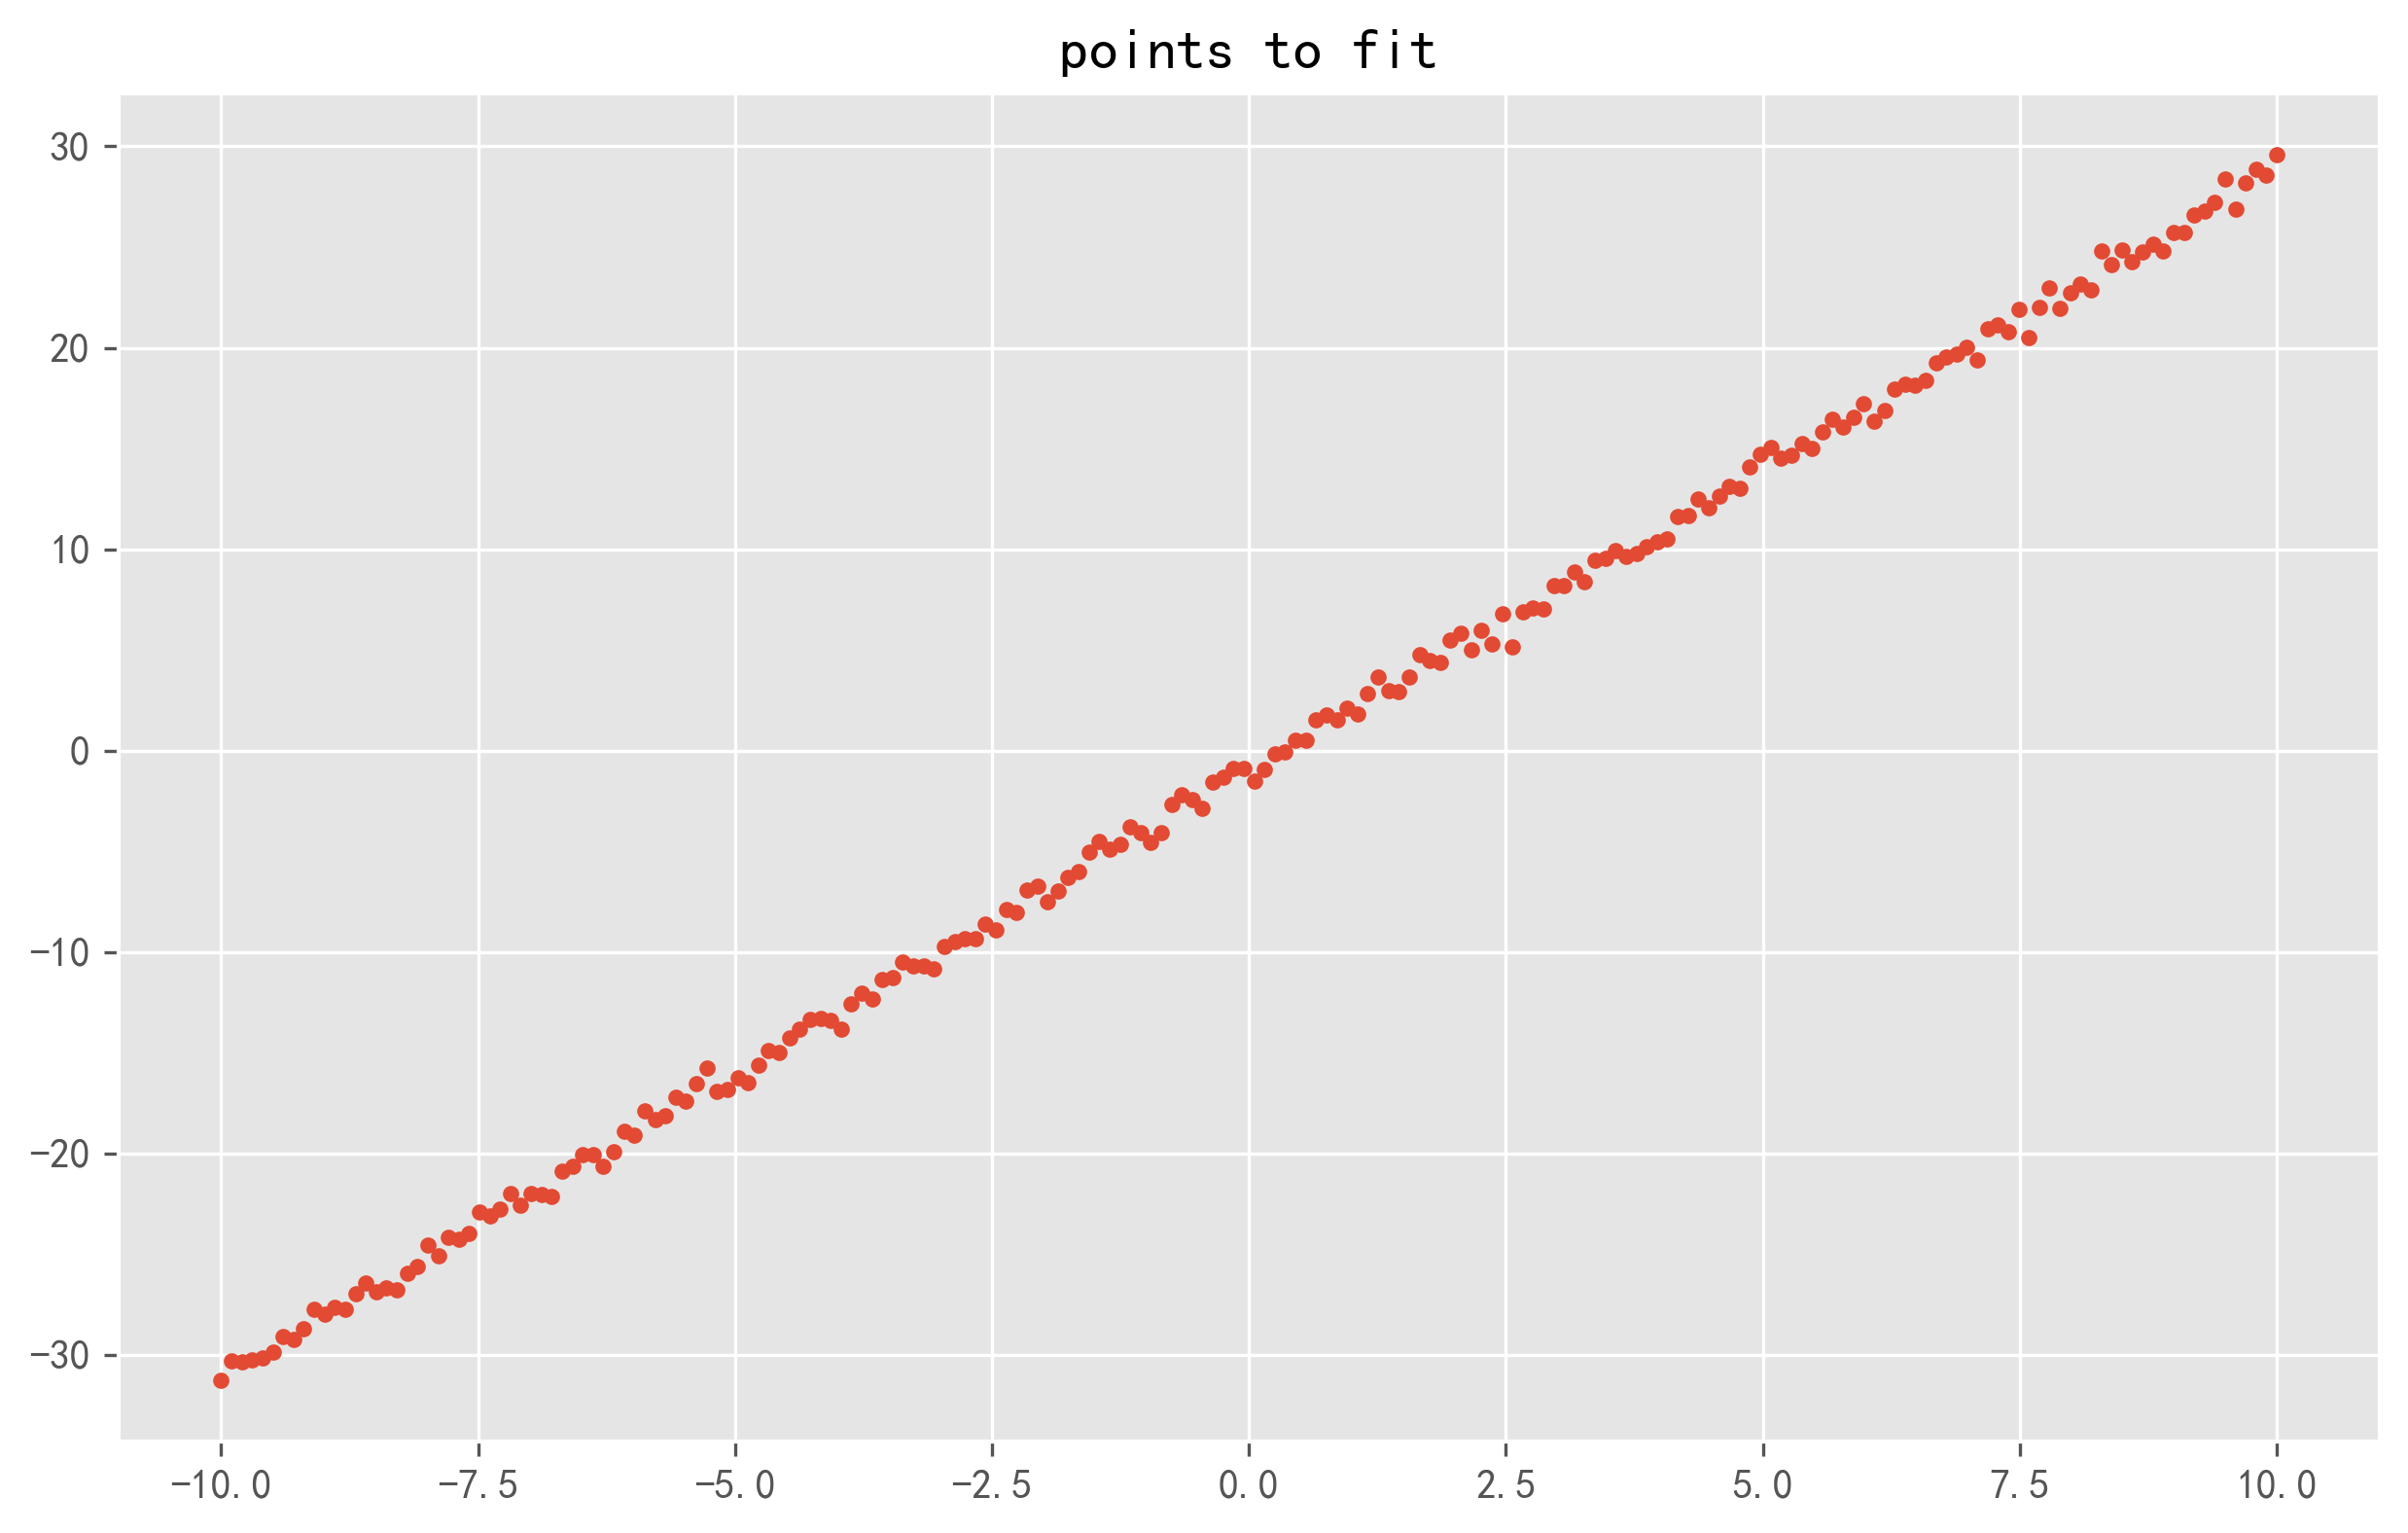

Epoch 0, Loss: 154.3087
Epoch 100, Loss: 50.2477
Epoch 200, Loss: 11.7434
Epoch 300, Loss: 1.9966
Epoch 400, Loss: 0.3865
Epoch 500, Loss: 0.2160
Epoch 600, Loss: 0.2045
Epoch 700, Loss: 0.2040
Epoch 800, Loss: 0.2040
Epoch 900, Loss: 0.2040
Epoch 999, Loss: 0.2040
True weight: 3.0, Learned weight: 2.9985
True bias: -1.0, Learned bias: -1.0250


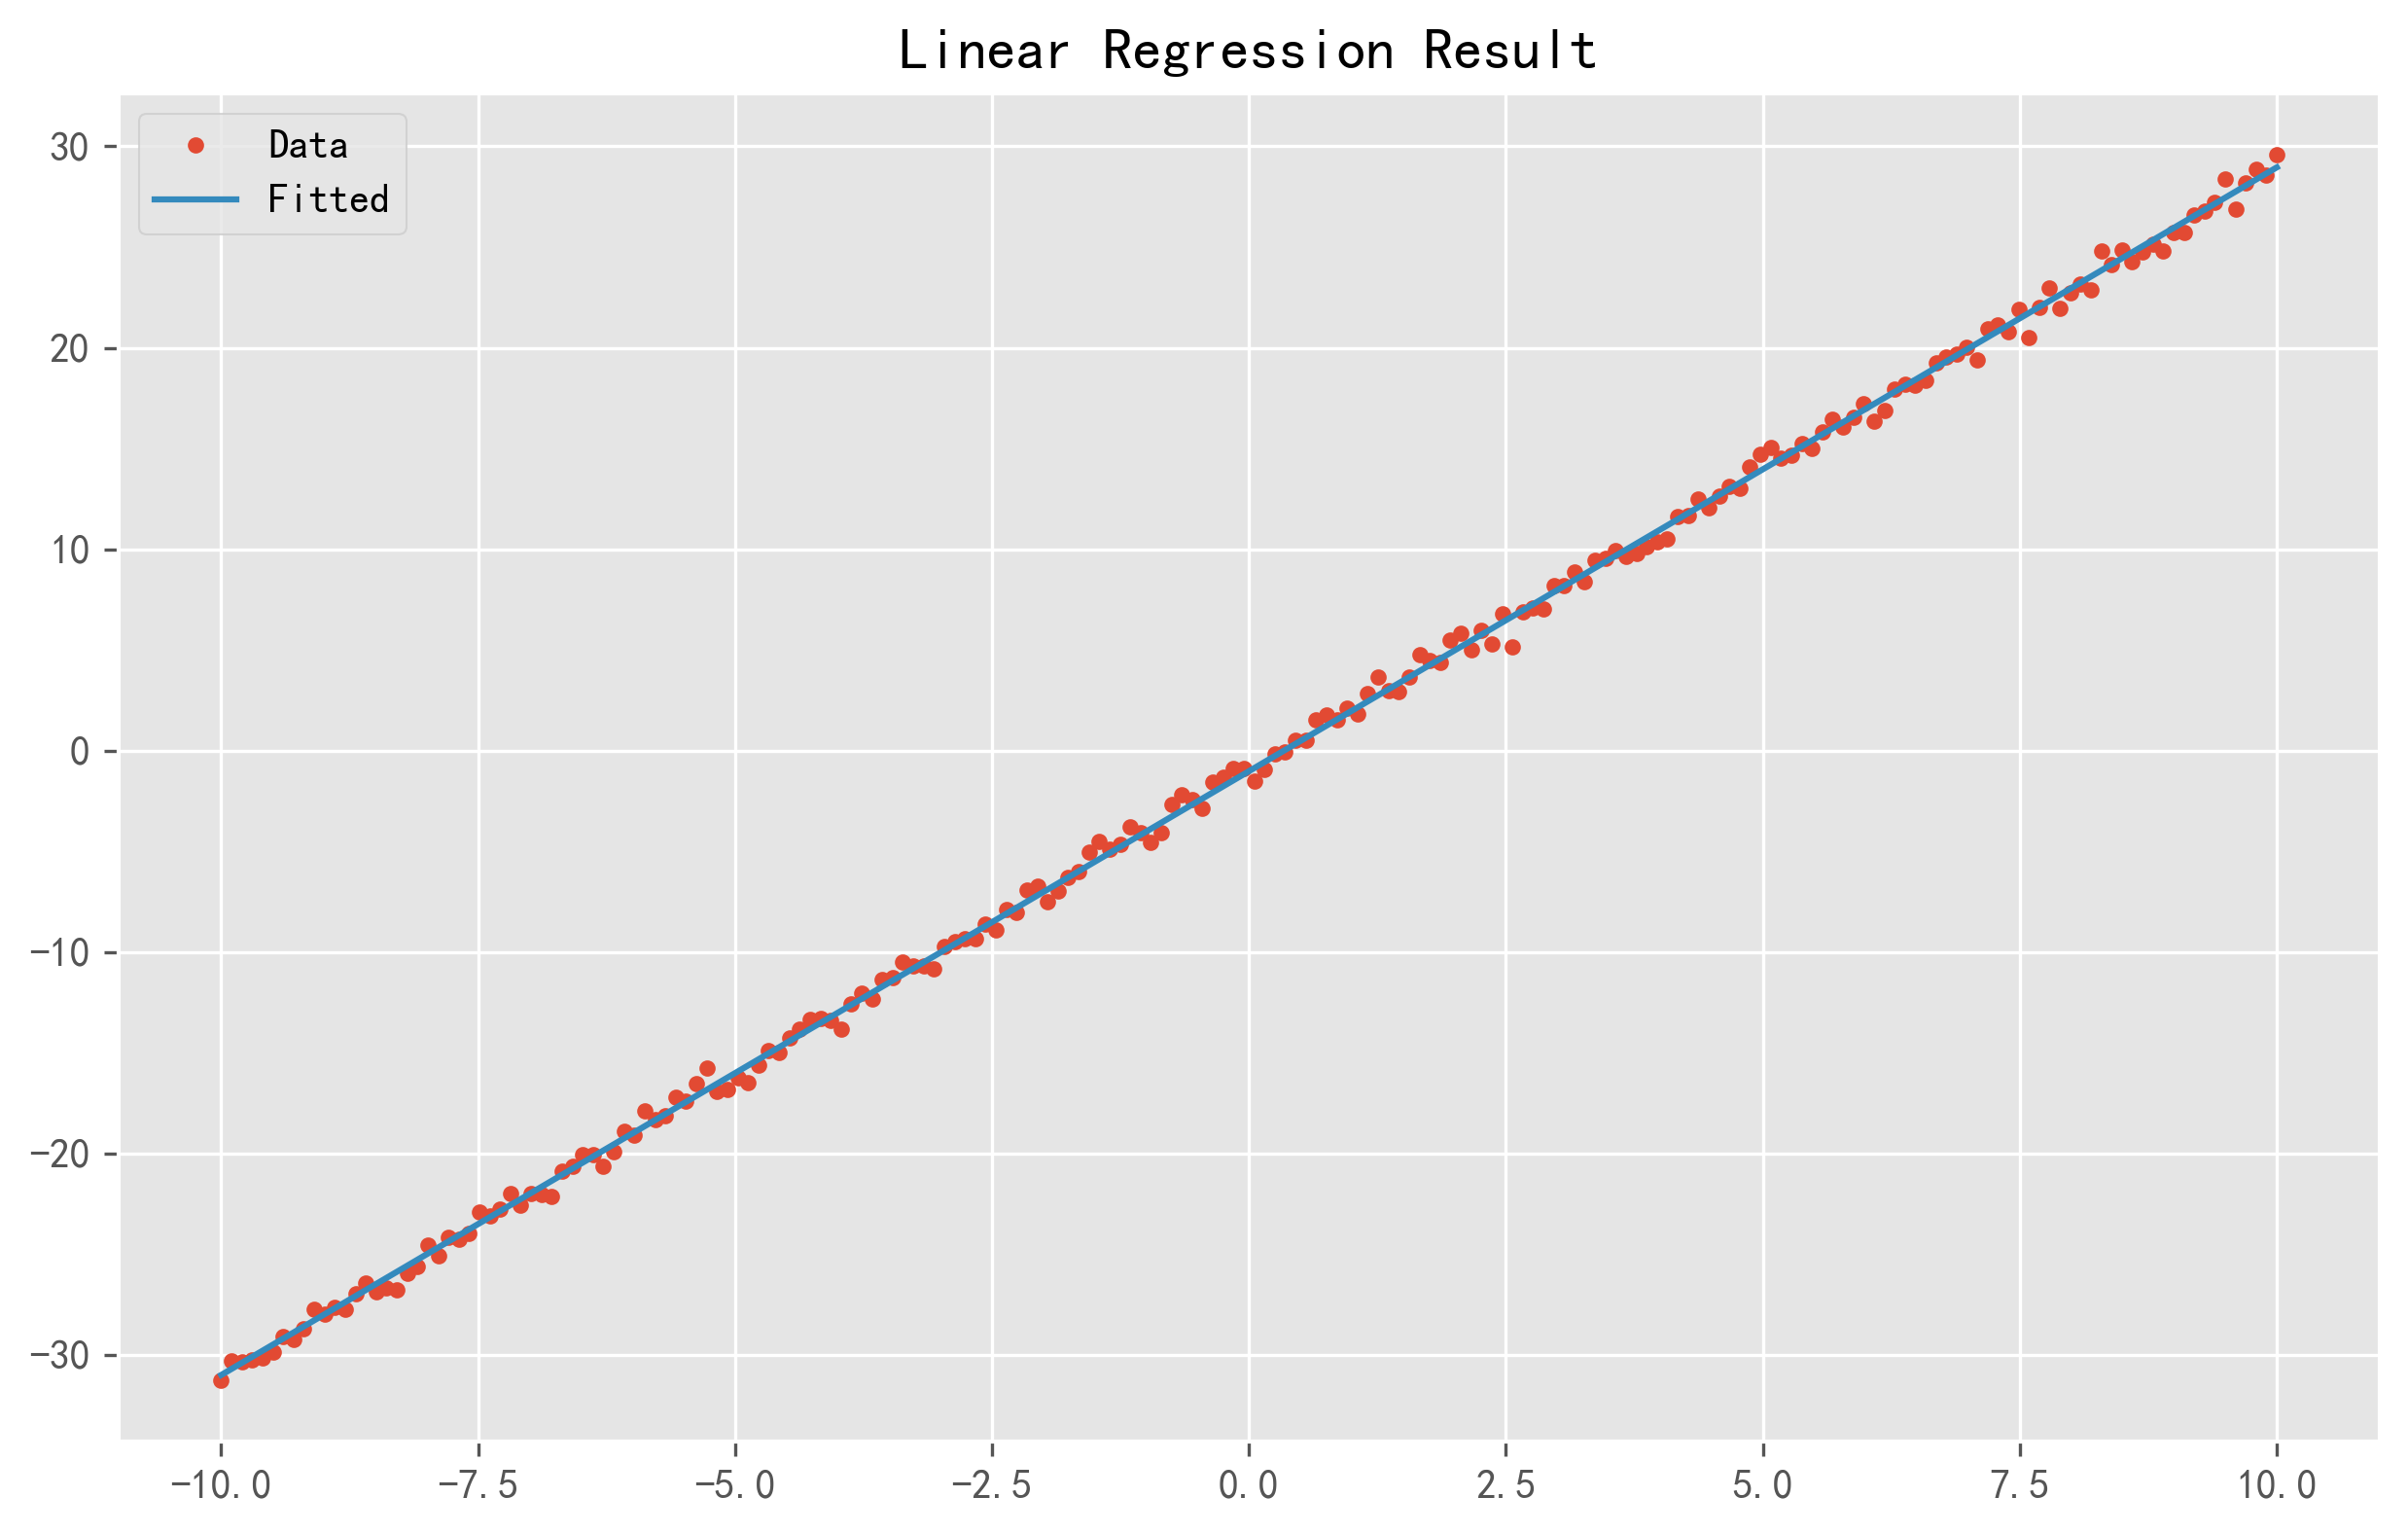

done


In [2]:
# 使用eqx.nn.Linear进行一维线性拟合
# 隔壁老王 2024-08-26

# 主要就三步:
# 1. 定义模型
# 2. 定义损失和梯度下降方法
# 3: 准备数据, 实例化模型与优化器, 进行训练和运行, 展示结果


import jax, optax
import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt


# step 1: 定义模型
class LinearNetwork(eqx.Module):
    layers: list # 通常都是好多层, 这里的单层反倒是例外了

    def __init__(self, key):
        # key1, key2, ... = jax.random.split(key, n)
        self.layers = [eqx.nn.Linear(1, 1, key=key),] # input:1, output:1

    def __call__(self, x):
        for layer in self.layers: x = layer(x)
        return x
#


# step 2: 定义损失和梯度下降方法
@eqx.filter_jit
#0# @eqx.filter_grad  # 将一个函数转换为只返回其梯度的函数
@eqx.filter_value_and_grad #1# # 将一个函数转换为 *同时返回损失的数值和梯度* 的函数
def loss_fn(model, x, y):
    pred_y = jax.vmap(model)(x) # 功能上等价于[model(xi) for xi in x], 速度上快得多
    return jnp.mean((pred_y - y) ** 2)
#


@eqx.filter_jit
def update(model, x, y, opt_state):
    #0# grads = loss_fn(model, x, y)
    loss_value, grads = loss_fn(model, x, y) #1# # 可以多返回个损失值, 默认就这么搞吧!
    updates, opt_state = optimizer.update(grads, opt_state, model) # 提供model参数, 以便在更新时考虑更多的内容
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value
#


# step 3: 准备数据, 实例化模型与优化器, 进行训练和运行, 展示结果
# 生成数据
key = jax.random.PRNGKey(0)
data_key, model_key = jax.random.split(key, 2)
x = jnp.linspace(-10, 10, 200)
true_weight, true_bias = 3.0, -1.0
y = true_weight * x + true_bias
y += jax.random.normal(data_key, y.shape)/2

# 将x(200,)改为x(200,1): 第一个维度为批量大小, 第二个为特征数量
# 这样转换是为了方便后面模型调用和训练......
x, y = jnp.expand_dims(x, axis=1), jnp.expand_dims(y, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(x, y, '.')
plt.title('points to fit')
plt.show()

# 初始化模型和优化器
model = LinearNetwork(model_key)
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array)) # opt_state记录了优化器的内部状态

# 训练循环
num_epochs = 1000
for epoch in range(num_epochs):
    model, opt_state, loss_value = update(model, x, y, opt_state)
    if epoch % (num_epochs//10) == 0 or epoch == num_epochs-1: print(f"Epoch {epoch}, Loss: {loss_value:.4f}")
#


# 运行并打印结果
learned_weight = model.layers[0].weight.squeeze().item() # squeeze移除所有大小为1的维度
learned_bias = model.layers[0].bias.item() # item将只包含一个元素的数组改为标量
print(f"True weight: {true_weight}, Learned weight: {learned_weight:.4f}")
print(f"True bias: {true_bias}, Learned bias: {learned_bias:.4f}")


# 绘制拟合结果
plt.figure(figsize=(10, 6))
plt.plot(x, y, '.', label='Data')
plt.plot(x, learned_weight * x + learned_bias, '-', label='Fitted')
plt.title('Linear Regression Result')
plt.legend()
plt.show()

print('done')

### 使用eqx.nn.Linear进行高维线性拟合

In [3]:
# 使用eqx.nn.Linear进行高维线性拟合
# 隔壁老王 2024-08-26

import jax, optax
import jax.numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt

# 设置维度
dim_in, dim_out = 3, 5
num_samples = 1000


# 1: 定义模型
class LinearNetwork(eqx.Module):
    layers: list # 通常都是好多层, 这里的单层反倒是例外了

    def __init__(self, dim_in, dim_out, key):
        # key1, key2, ... = jax.random.split(key, n)
        self.layers = [eqx.nn.Linear(dim_in, dim_out, key=key),] # input:dim_in, output:dim_out (与一维的对比)

    def __call__(self, x):
        for layer in self.layers: x = layer(x)
        return x
#


# 2: 定义损失及其梯度下降
@eqx.filter_jit
#0# @eqx.filter_grad  # 将一个函数转换为只返回其梯度的函数
@eqx.filter_value_and_grad #1# # 将一个函数转换为 *同时返回损失的数值和梯度* 的函数
def loss_fn(model, x, y):
    pred_y = jax.vmap(model)(x)
    return jnp.mean((pred_y - y) ** 2)
#


@eqx.filter_jit
def update(model, x, y, opt_state):
    #0# grads = loss_fn(model, x, y)
    loss_value, grads = loss_fn(model, x, y) #1# # 可以多返回个损失值, 默认就这么搞吧!
    updates, opt_state = optimizer.update(grads, opt_state, model) # 提供model参数, 以便在更新时考虑更多的内容
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value
#


# 3: 其他部分(main)
# 生成数据
key = jax.random.PRNGKey(0)
x_key, y_key, w_key, b_key, model_key = jax.random.split(key, 5)

x = jax.random.normal(x_key, (num_samples, dim_in)) # 每行一个样本
true_weight, true_bias = jax.random.normal(w_key, (dim_out, dim_in)), jax.random.normal(b_key, (dim_out,))
y = jnp.dot(x, true_weight.T) + true_bias  # 注意: 权重真值是(dim_out, dim_in)形状的, 因为eqx.nn.Linear默认的就如此
y += jax.random.normal(y_key, y.shape)/5

# 初始化模型和优化器
model = LinearNetwork(dim_in, dim_out, model_key)
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array)) # 状态记录了优化器的内部状态: 动量, 学习率等

# 训练循环
num_epochs = 1000
for epoch in range(num_epochs):
    model, opt_state, loss_value = update(model, x, y, opt_state)
    if epoch % (num_epochs//10) == 0 or epoch == num_epochs-1: print(f"Epoch {epoch}, Loss: {loss_value:.4f}")
#

print()

# 打印结果
learned_weight = model.layers[0].weight # squeeze移除所有大小为1的维度
learned_bias = model.layers[0].bias # item将只包含一个元素的数组改为标量
print(f"True weight: {true_weight}, \nLearned weight: {learned_weight}\n")
print(f"True bias: {true_bias}, \nLearned bias: {learned_bias}")

print()

# 计算平均绝对误差(abs是逐元素求绝对值, mean是对所有元素求平均)
weight_mae = jnp.mean(jnp.abs(true_weight - learned_weight))
bias_mae = jnp.mean(jnp.abs(true_bias - learned_bias))
print('Mean Absolute Error of weight:', weight_mae)
print('Mean Absolute Error of bias:', bias_mae)

print('\ndone')

Epoch 0, Loss: 2.3440
Epoch 100, Loss: 0.2637
Epoch 200, Loss: 0.0542
Epoch 300, Loss: 0.0402
Epoch 400, Loss: 0.0397
Epoch 500, Loss: 0.0397
Epoch 600, Loss: 0.0397
Epoch 700, Loss: 0.0397
Epoch 800, Loss: 0.0397
Epoch 900, Loss: 0.0397
Epoch 999, Loss: 0.0397

True weight: [[ 0.38036022  0.9652231  -0.6668677 ]
 [-0.35439548 -0.65022326 -1.814848  ]
 [ 0.7212864  -0.04088091 -0.668466  ]
 [ 0.3490203  -0.1442865  -0.51130664]
 [-0.01088442 -0.12180664  0.5159973 ]], 
Learned weight: [[ 0.3731779   0.96749985 -0.6625251 ]
 [-0.36139658 -0.63891333 -1.820515  ]
 [ 0.7186097  -0.03406974 -0.6621144 ]
 [ 0.3440392  -0.14154465 -0.52506727]
 [-0.01351357 -0.11839668  0.5047054 ]]

True bias: [ 0.82501215  0.88014925 -1.1567166  -0.03485729  0.41830334], 
Learned bias: [ 0.8345427   0.87092566 -1.1537249  -0.03847089  0.4110168 ]

Mean Absolute Error of weight: 0.0061622537
Mean Absolute Error of bias: 0.006529191

done


### CNN进行MNIST手写数字识别

In [4]:
# https://docs.kidger.site/equinox/examples/mnist/
# copy官方的CNN例子, 只是dataloader改成了tf的(我这torch有点问题), 并做了略微的简化和修改

import jax
import jax.numpy as jnp
import equinox as eqx
import optax
#
import tensorflow as tf
import tensorflow_datasets as tfds
from jaxtyping import Array, Float, Int, PyTree

# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
STEPS = 1000
PRINT_EVERY = 100
SEED = 137 # 结构常数的倒数(近似值)

key = jax.random.PRNGKey(SEED)

print('eqx mnist example')
# 使用 TensorFlow 数据集
def normalize_img(image, label): return tf.cast(image, tf.float32) / 255., label
# cast: `uint8` -> `float32` 显式转化, 可以提高代码的可读性和可维护性, 并提高性能
# Normalizes使得像素值的范围从0-255变为0.-1., 有利于保持数值的稳定性
# (靠近0时激活函数敏感, 且反向传播时权重更新不至于太大)

# 从tf的数据集中加载 MNIST 数据并划分为训练集和测试集. as_supervised=True表示数据以(图像,标签)的形式组织 
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

def prepare_dataset(dataset, is_training=True):
    dataset = dataset.map(normalize_img)    # Step 1: 应用数据预处理
    dataset = dataset.cache()    # Step 2: 缓存数据(将数据加载到内存)
    if is_training: dataset = dataset.shuffle(10000)    # Step 3: 打乱数据(仅对训练集, 测试集通常无需打乱)
    dataset = dataset.batch(BATCH_SIZE)    # Step 4: 分批(将训练数据分批, 每批包含BATCH_SIZE个图片)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)    # Step 5: 预取数据(预加载数据, 提高训练效率)
    return dataset

# 应用到训练集和测试集
train_ds = prepare_dataset(train_ds, is_training=True)
test_ds = prepare_dataset(test_ds, is_training=False)
print('dataloader prepared')

# ======

class CNN(eqx.Module):
    layers: list

    def __init__(self, key):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        # Standard CNN setup: convolutional layer, followed by flattening,
        # with a small MLP on top.
        self.layers = [  # 对原来的结构进行了微调
            eqx.nn.Conv2d(1, 8, kernel_size=3, padding=1, key=key1), # 单通道(灰度) 到 x通道
            eqx.nn.MaxPool2d(kernel_size=2), # 2x2最大池化
            eqx.nn.Conv2d(8, 16, kernel_size=3, padding=1, key=key1),
            eqx.nn.MaxPool2d(kernel_size=2),
            # jax.nn.relu, # 非线性激活??
            jnp.ravel, # 将卷积层的输出(通道x高度x宽度)展平, 以便连接到全连接层
            eqx.nn.Dropout(p=1/2), # 这里增加了一个dropout
            eqx.nn.Linear(10816, 1024, key=key2),
            # jax.nn.sigmoid, # 为什么出现在这里?? 为了将数值压缩的0-1? 还是为了引入非线性?
            eqx.nn.Dropout(p=1/2), # 改为dropout了
            jax.nn.selu, # 增加非线性函数
            eqx.nn.Linear(1024, 64, key=key3),
            eqx.nn.Dropout(p=1/2), # 这里增加了一个dropout
            # jax.nn.relu, # 这里也去掉了...
            eqx.nn.Linear(64, 10, key=key4),
            jax.nn.log_softmax,
        ]

    def __call__(self, x: Float[Array, "1 28 28"]) -> Float[Array, "10"]:
        for layer in self.layers:
                x = layer(x, key=jax.random.PRNGKey(1912)) if isinstance(layer, eqx.nn.Dropout) else layer(x)
        return x
#


key, subkey = jax.random.split(key, 2)
model = CNN(subkey)

@eqx.filter_jit # JIT our loss function
@eqx.filter_value_and_grad
def loss_fn(model: CNN, x: Float[Array, "batch 1 28 28"], y: Int[Array, " batch"]) -> Float[Array, ""]:
    pred_y = jax.vmap(model)(x)
    return cross_entropy(y, pred_y)

def cross_entropy(y: Int[Array, " batch"], pred_y: Float[Array, "batch 10"]) -> Float[Array, ""]:
    '''
        H(y, p) = -Σ y_i * log(p_i), y_i是真实标签(1hot编码), p_i是预测概率
        交叉熵天然地适合多分类问题, mse更适合回归问题
    '''
    pred_y = jnp.take_along_axis(pred_y, jnp.expand_dims(y, 1), axis=1) # arr, idx, axis: 在axis轴根据idx提取arr中的数据
    return -jnp.mean(pred_y) # log操作已经在网络的最后一层实现了


@eqx.filter_jit
def compute_accuracy(model: CNN, x: Float[Array, "batch 1 28 28"], y: Int[Array, " batch"]) -> Float[Array, ""]:
    # 计算准确率
    pred_y = jax.vmap(model)(x)
    pred_y = jnp.argmax(pred_y, axis=1)
    return jnp.mean(y == pred_y)
#

def evaluate(model: CNN, test_ds: tf.data.Dataset):
    # 评估在测试集上的性能
    avg_loss = 0
    avg_acc = 0
    num_batches = 0
    for x, y in test_ds:
        x = jnp.transpose(x.numpy(), (0, 3, 1, 2))  # 调整维度顺序
        y = y.numpy()
        avg_loss += loss_fn(model, x, y)[0]
        avg_acc += compute_accuracy(model, x, y)
        num_batches += 1
    return avg_loss / num_batches, avg_acc / num_batches
#

# evaluate(model, test_ds)

optim = optax.adamw(LEARNING_RATE)

def train(model: CNN, train_ds: tf.data.Dataset, test_ds: tf.data.Dataset,
          optim: optax.GradientTransformation, steps: int, print_every: int,) -> CNN:

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(model: CNN, opt_state: PyTree, x: Float[Array, "batch 1 28 28"], y: Int[Array, " batch"]):
        loss_value, grads = loss_fn(model, x, y)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
    #

    train_iter = iter(train_ds.repeat())

    for step in range(steps):
        x, y = next(train_iter)
        x = jnp.transpose(x.numpy(), (0, 3, 1, 2))  # 调整维度顺序
        y = y.numpy()
        model, opt_state, train_loss = make_step(model, opt_state, x, y)
        if (step % print_every) == 0 or (step == steps - 1):
            test_loss, test_accuracy = evaluate(model, test_ds)
            print(
                f"{step=}, train_loss={train_loss.item()}, "
                f"test_loss={test_loss.item()}, test_accuracy={test_accuracy.item()}"
            )
    return model

print('model training')
model = train(model, train_ds, test_ds, optim, STEPS, PRINT_EVERY)
print('done')

eqx mnist example
dataloader prepared
model training
step=0, train_loss=2.312948226928711, test_loss=4.159948825836182, test_accuracy=0.1978503167629242
step=100, train_loss=0.31067898869514465, test_loss=0.23075751960277557, test_accuracy=0.9305334687232971
step=200, train_loss=0.14190813899040222, test_loss=0.16108457744121552, test_accuracy=0.9505374431610107
step=300, train_loss=0.18906579911708832, test_loss=0.10662969201803207, test_accuracy=0.9653662443161011
step=400, train_loss=0.04264126718044281, test_loss=0.09975390136241913, test_accuracy=0.9671576619148254
step=500, train_loss=0.12188808619976044, test_loss=0.09193980693817139, test_accuracy=0.9710389971733093
step=600, train_loss=0.07940927147865295, test_loss=0.13892574608325958, test_accuracy=0.9575039744377136
step=700, train_loss=0.17864038050174713, test_loss=0.08730199187994003, test_accuracy=0.972034215927124
step=800, train_loss=0.19522911310195923, test_loss=0.06590718030929565, test_accuracy=0.9772093892097473


### 使用RNN(GRU)进行时间序列分析:
- 分类顺时针和逆时针的螺旋
- 演示如何在模型中使用自定义参数

In [5]:
# https://docs.kidger.site/equinox/examples/train_rnn/
# This is an introductory example. We demonstrate what using Equinox normally looks like day-to-day.
# Here, we'll train an RNN (GRU based) to classify clockwise vs anticlockwise spirals.

import math
import numpy as np
#
import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx
import optax  # https://github.com/deepmind/optax
import matplotlib.pyplot as plt


# setting up a very simple dataloader, and generating a toy dataset of spirals (螺旋地)
def dataloader(arrays, batch_size):
    '''
    创建数据加载器: 将输入数据数组分割成批次，并无限循环地生成这些批次。
    - `arrays`:  一个包含多个数组的元组，每个数组代表一个数据特征。所有数组的第一维度必须相等，表示样本数量。
    - `batch_size`:  每个批次包含的样本数量。

    '''
    dataset_size = arrays[0].shape[0] # 获取样本数量(称为数据集大小)
    assert all(array.shape[0] == dataset_size for array in arrays) # 确保所有输入数组的样本数量一致
    indices = np.arange(dataset_size) # 创建一个包含所有样本索引的数组
    #
    while True: # 无限循环，持续地生成数据batch
        perm = np.random.permutation(indices) # 将样本索引随机打乱
        start, end = 0, batch_size     # 初始化批次起始和结束索引
        while end <= dataset_size:     # 生成一个批次
            batch_perm = perm[start:end] # 获取当前批次的样本索引
            yield tuple(array[batch_perm] for array in arrays) # 根据索引获取样本数据，并打包成元组
            start = end
            end = start + batch_size
#

def get_data(dataset_size, *, key):
    '''
    生成一个包含(正转/反转)两个形状的螺旋线二分类数据集。
    - `dataset_size`: 数据集大小，即样本数量。
    - `key`: JAX 随机数生成器密钥，用于控制数据的随机性。

    '''
    t = jnp.linspace(0, 2 * math.pi, 16)  # 生成一个从 0 到 2π 的均匀分布的数组，用于控制螺旋线的角度
    offset = jrandom.uniform(key, (dataset_size, 1), minval=0, maxval=2 * math.pi) # 为每个样本生成一个随机的角度偏移
    x1 = jnp.sin(t + offset) / (1 + t) # 螺旋线的 x 坐标，注意 `(1 + t)` 将使螺旋线的口径随着角度的增大而逐渐缩小
    x2 = jnp.cos(t + offset) / (1 + t) # y 坐标
    y = jnp.ones((dataset_size, 1))    # 初始化所有样本的标签为 1
    #
    half_dataset_size = dataset_size // 2
    x1 = x1.at[:half_dataset_size].multiply(-1) # 将前一半样本的 x 坐标乘以 -1，使它们翻转到另一侧，形成单独的螺旋线
    y = y.at[:half_dataset_size].set(0) # 将前一半样本的标签设置为 0，实现二分类
    x = jnp.stack([x1, x2], axis=-1) #  将 x1 和 x2 沿着最后一个维度堆叠，形成最终的特征数据
    #
    return x, y # x是位置坐标, y是标签
#


# Now for our model.
# 
# Here, we handle the final adding on of bias ourselves, rather than letting the `linear` layer do it.
# This is just so we can demonstrate how to use custom parameters in models.
#
# 用 Equinox 构建一个简单的循环神经网络模型，并演示了如何自定义模型参数和前向传播逻辑。
# 通过手动添加偏置项，我们可以更灵活地控制模型的行为，并实现一些特殊的功能。
class RNN(eqx.Module): # `eqx.Module` 是 Equinox 中用于构建模型的基本单元
    hidden_size: int  # 定义为类属性，是为了在初始化 `RNN` 对象时，将其作为参数传递给对象的构造函数，并在整个模型中共享这个值
    # 这样做可以确保模型的不同部分使用相同的隐藏层大小，并提高代码的可读性
    cell: eqx.Module  # 这里还定义了子模型: RNN 单元(GRU单元，用于处理序列数据)、线性层和偏置项
    linear: eqx.nn.Linear # 线性层，将 GRU 的输出映射到最终的输出维度
    bias: jax.Array
    ''' # 我其实更喜欢下面这种方式, 因为
        1. 灵活：可以轻松地添加、删除或更改层，而不需要修改模型的基本结构。
        2. 安全：使用类型注解和 Union 类型，保持了良好的类型提示和检查。与JIT编译和其他功能完全兼容。
        3. 明确：仍然保留了关键参数如 input_size, hidden_sizes, output_size 的明确声明。
    layers: eqx.nn.Sequential
    input_size: int
    hidden_sizes: Tuple[int, ...]
    output_size: int
    '''

    def __init__(self, in_size, out_size, hidden_size, *, key):
        '''
        构造函数，用于初始化模型参数
        - `in_size`:  输入数据的维度。
        - `out_size`:  输出数据的维度。
        - `hidden_size`:  GRU 隐藏层的维度。
        - `key`:  JAX 随机数生成器密钥，用于初始化模型参数。
        '''
        ckey, lkey = jrandom.split(key)
        self.hidden_size = hidden_size # 将 `hidden_size` 参数的值存储到类属性中
        self.cell = eqx.nn.GRUCell(in_size, hidden_size, key=ckey) # `初始化模型参数
        self.linear = eqx.nn.Linear(hidden_size, out_size, use_bias=False, key=lkey) # 线性层设置为无偏置，后面将手动添加偏置项
        self.bias = jnp.zeros(out_size) # 零初始化的偏置向量


    def __call__(self, input):
        '''
        定义了 `RNN` 对象的可调用方法，用于执行前向传播
        '''
        hidden = jnp.zeros((self.hidden_size,)) # 初始化 GRU 的隐藏状态为零向量
        def f(carry, inp): return self.cell(inp, carry), None # 用于调用 GRU 单元: carry是GRU隐态, inp表示当前时间步的输入
        out, _ = lax.scan(f, hidden, input) # 使用 `lax.scan` 函数迭代地将输入序列送入 GRU 单元，并获取最终的输出序列和隐藏状态
        # lax是jax的一个基元操作模块, 用于支持线性代数运算和流控制等
        out2 = self.linear(out) + self.bias # 将 GRU 的输出序列送入线性层，并手动添加偏置项
        return jax.nn.sigmoid(out2) # 使用 sigmoid 函数将输出值映射到 0 到 1 之间，用于二分类任务
#


# training loop # # # 用来训练和评估RNN模型的完整循环
dataset_size=10000  # 数据集大小(制作多少个样本)
batch_size=32       # 每个批次的样本数
learning_rate=3e-3  # 学习率
steps=200           # 训练步数
hidden_size=16      # RNN 隐藏层的尺寸

# 生成数据并创建数据加载器
data_key, model_key = jrandom.split(jrandom.PRNGKey(137), 2)
xs, ys = get_data(dataset_size, key=data_key) # xs是位置坐标, ys是标签
data_iter = dataloader((xs, ys), batch_size)

model = RNN(in_size=2, out_size=1, hidden_size=hidden_size, key=model_key) # 创建 RNN 模型实例


#  定义二元交叉熵损失函数
@eqx.filter_value_and_grad # 使用装饰器来计算梯度
def loss_fn(model, x, y):
    pred_y = jax.vmap(model)(x)
    # Trains with respect to binary cross-entropy
    return -jnp.mean(y * jnp.log(pred_y) + (1 - y) * jnp.log(1 - pred_y))
#


# 定义单个训练步骤，包括计算损失、梯度、更新模型参数
# Important for efficiency whenever you use JAX: wrap everything into a single JIT region
@eqx.filter_jit # 使用装饰器来进行即时编译以提高效率
def make_step(model, x, y, opt_state):
    loss, grads = loss_fn(model, x, y)
    updates, opt_state = optim.update(grads, opt_state, model) # 对有些优化算法, 加model参数会有益
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state
#

# 创建 Adam 优化器并初始化优化器状态
optim = optax.adam(learning_rate)
opt_state = optim.init(model) # 优化器的内部状态, 许多现代优化算法不仅仅依赖当前的梯度来更新模型参数

# 执行训练步骤，更新模型参数，并打印每一步的损失
for step, (x, y) in zip(range(steps), data_iter):
    loss, model, opt_state = make_step(model, x, y, opt_state)
    if step % 20 == 0: print(f"step={step}, loss={loss.item()}")
#

# 在整个数据集上评估模型，计算并打印最终的准确率
pred_ys = jax.vmap(model)(xs)
num_correct = jnp.sum((pred_ys > 0.5) == ys)
final_accuracy = (num_correct / dataset_size).item()
print(f"final_accuracy={final_accuracy}")


# `eqx.filter_value_and_grad` will calculate the gradient with respect to all floating-point arrays in the first argument (`model`).
# In this case the `model` parameters will be differentiated,
# whilst `model.hidden_size` is an integer and will get `None` as its gradient.
#
# Likewise, `eqx.filter_jit` will look at all the arguments passed to `make_step`, and automatically:
# JIT-trace every array, and JIT-static everything else.
#
# In this case the `model` parameters and the data `x` and `y` will be traced,
# whilst `model.hidden_size` is an integer and will be static'd instead.
# 模型参数和数据`x`&`y`将被跟踪, 同时, 整数`model.hidden_size`将被静态化.


step=0, loss=0.6962582468986511
step=20, loss=0.6866487264633179
step=40, loss=0.690660834312439
step=60, loss=0.6866141557693481
step=80, loss=0.7016385793685913
step=100, loss=0.6936661005020142
step=120, loss=0.688828706741333
step=140, loss=0.6813316345214844
step=160, loss=0.3454262614250183
step=180, loss=0.019810283556580544
final_accuracy=1.0


### 使用GRU进行时间序列预测

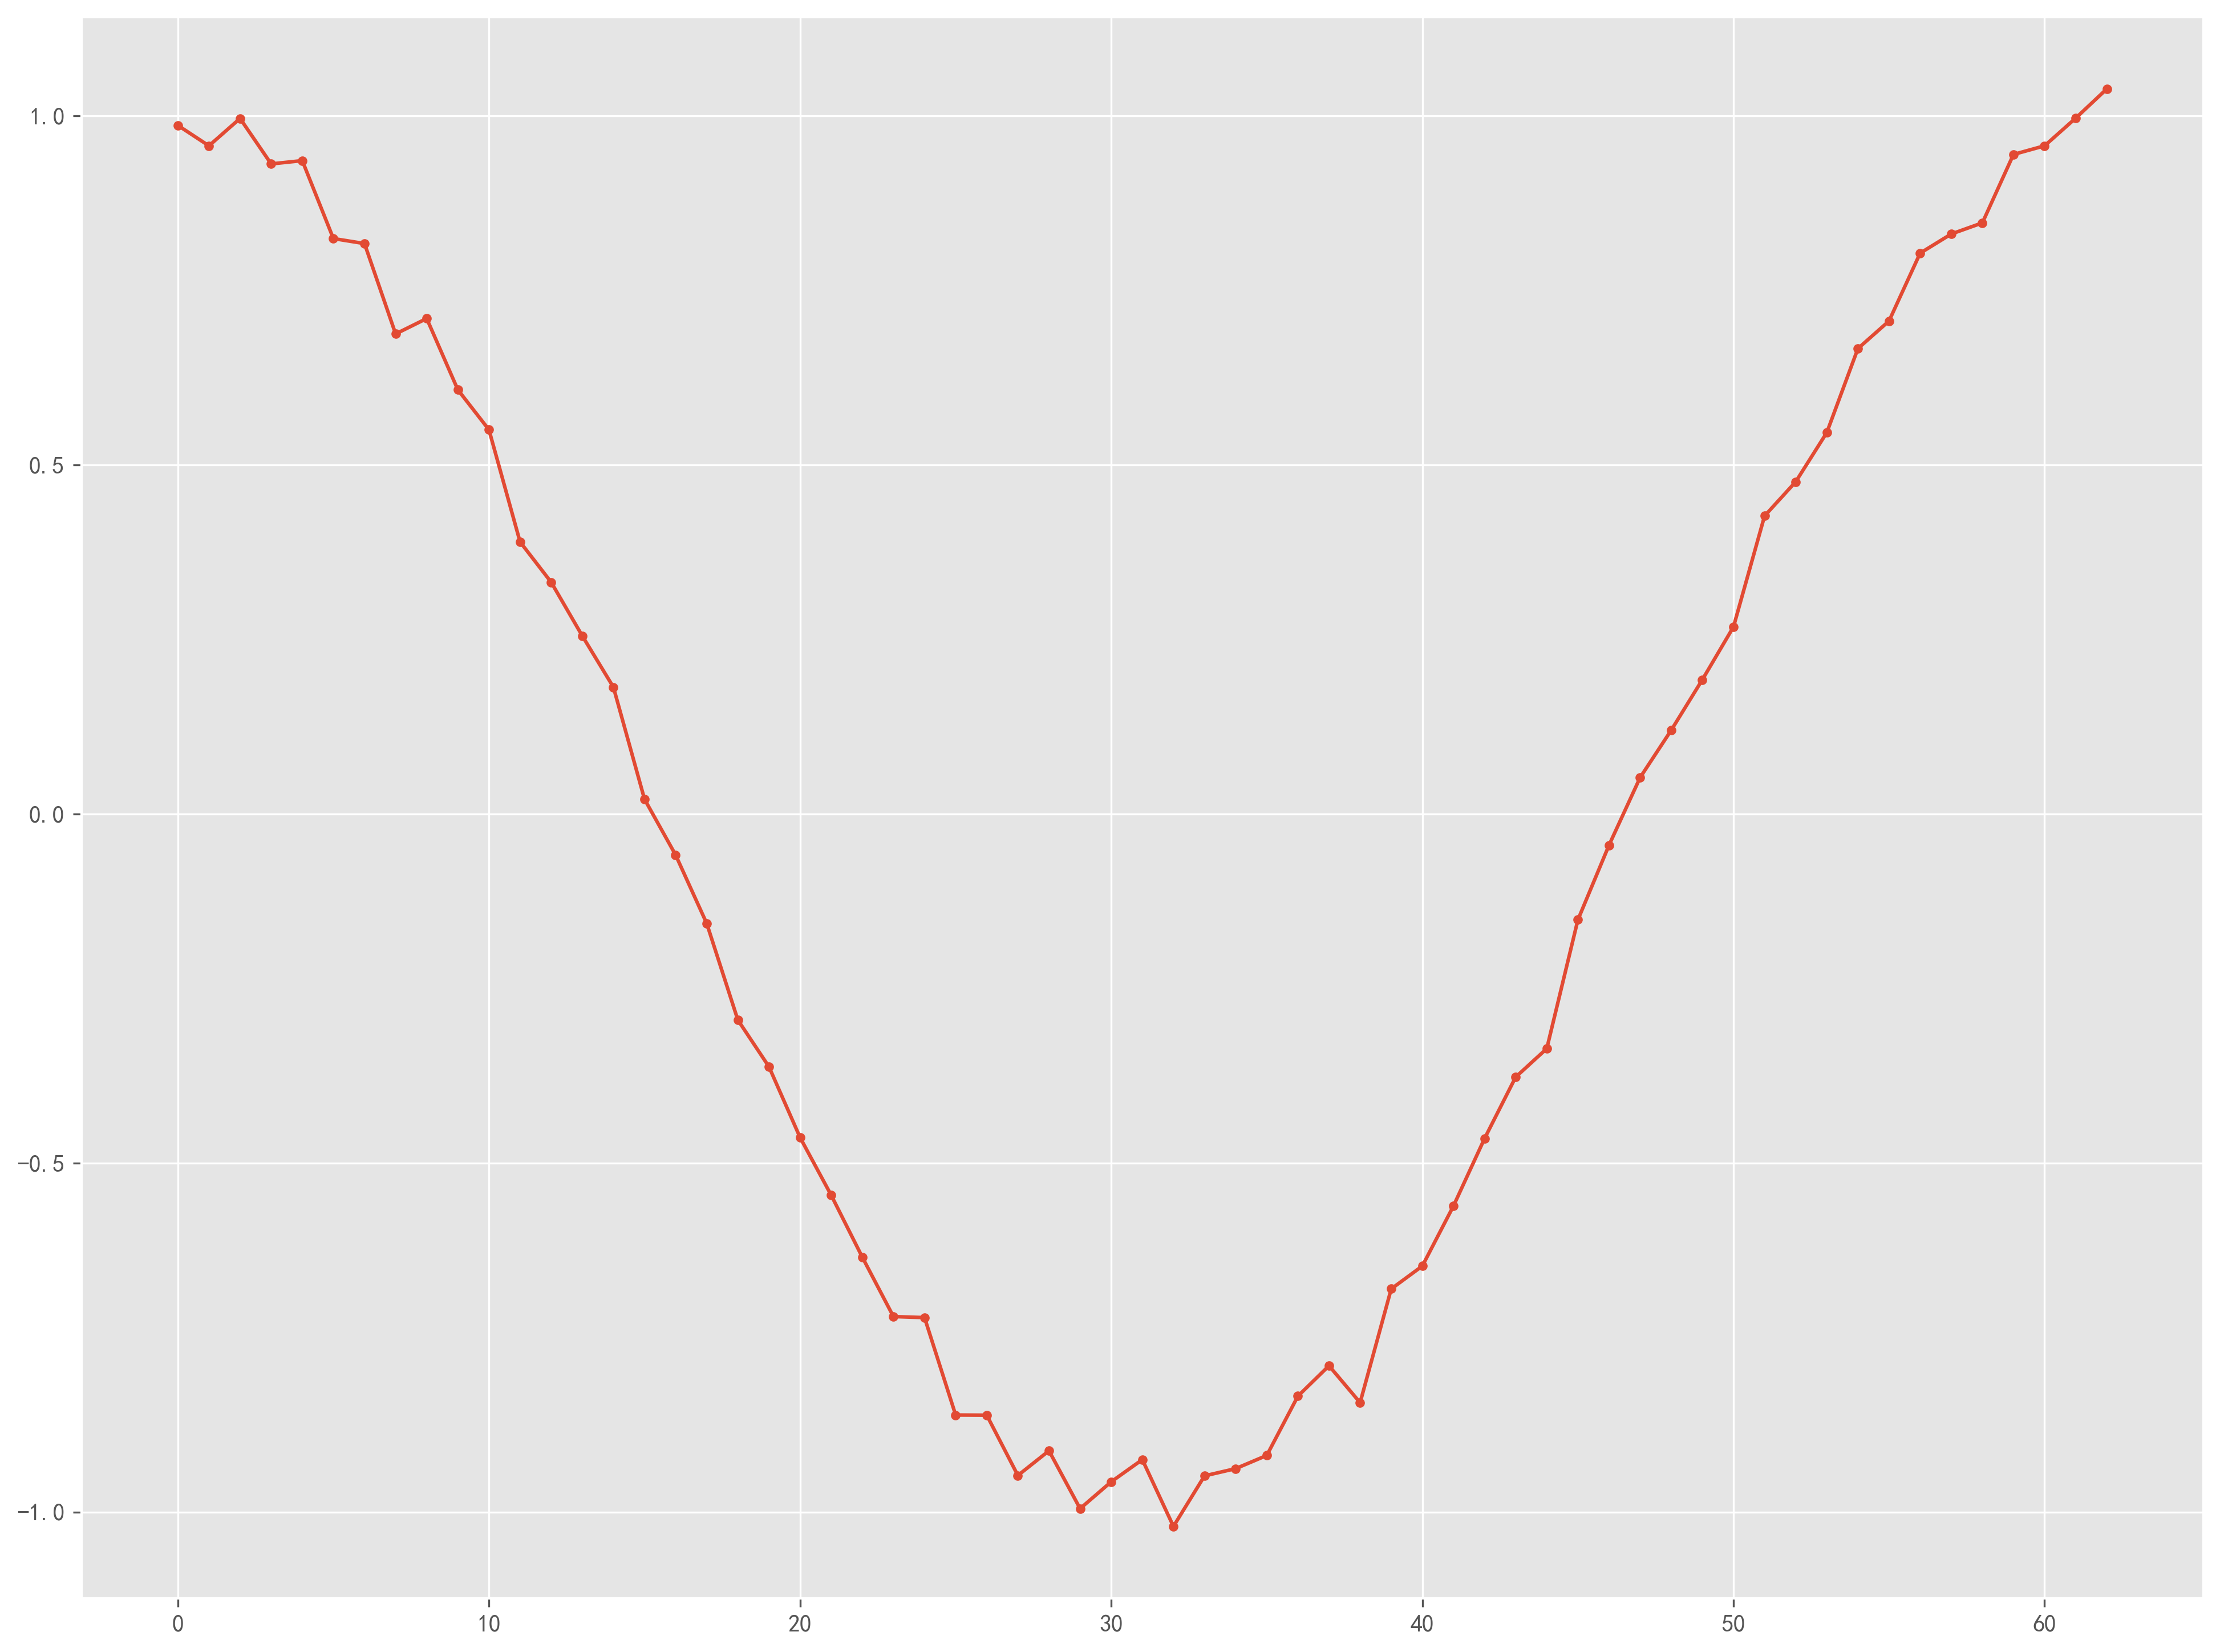

data shapes: (100, 63, 1) (100, 1)
Epoch 1/100, Loss: 0.0319
Epoch 11/100, Loss: 0.0003
Epoch 21/100, Loss: 0.0000
Epoch 31/100, Loss: 0.0000
Epoch 41/100, Loss: 0.0000
Epoch 51/100, Loss: 0.0000
Epoch 61/100, Loss: 0.0000
Epoch 71/100, Loss: 0.0000
Epoch 81/100, Loss: 0.0000
Epoch 91/100, Loss: 0.0000
Prediction: 0.8680



In [6]:
# 使用GRU进行时间序列预测
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
from typing import List, Tuple

# 生成示例数据
def generate_data(n_sequences, seq_length=50):
    '''
    n_sequences: 多少个数据序列
    seq_length: 每个数据序列多长
    '''
    x = jnp.arange(n_sequences*seq_length*10)
    y = jnp.sin(0.1 * x) + 0.03*jax.random.normal(jax.random.PRNGKey(0), x.shape)
    #
    xs, ys = [], []
    for _ in range(n_sequences):
        start = jax.random.randint(jax.random.PRNGKey(0), (), 0, n_sequences-seq_length)
        xs.append(y[start:start+seq_length])
        ys.append(jnp.sin(0.1 * x[start+seq_length]))
    #
    return jnp.array(xs), jnp.array(ys)
#

n_sequences = 100 # 多少组用于训练的数据
seq_length = 63 # 每组数据(的x)有多长(y总是一个)

# 生成数据, 并示例
x_data, y_data = generate_data(n_sequences, seq_length)
plt.plot(x_data[0], '.-')
plt.show()


# 定义GRU模型
class GRU(eqx.Module):
    hidden_size: int
    input_size: int
    output_size: int
    gru_cell: eqx.nn.GRUCell
    linear: eqx.nn.Linear

    def __init__(self, input_size, hidden_size, output_size, key):
        gru_key, linear_key = jax.random.split(key)
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.gru_cell = eqx.nn.GRUCell(input_size, hidden_size, key=gru_key)
        self.linear = eqx.nn.Linear(hidden_size, output_size, key=linear_key)

    def __call__(self, xs: jnp.ndarray) -> jnp.ndarray:
        h = jnp.zeros((self.hidden_size,))
        for x in xs: h = self.gru_cell(x, h) # 待优化?
        return self.linear(h)
#


# 训练函数
@eqx.filter_value_and_grad
def compute_loss(model: GRU, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    pred = jax.vmap(model)(x)
    return jnp.mean((pred - y) ** 2)

@eqx.filter_jit
def make_step(model: GRU, x: jnp.ndarray, y: jnp.ndarray, opt_state, optimizer):
    loss, grads = compute_loss(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state


# 主函数
def main():
    global x_data, y_data, seq_length
    # 设置参数
    input_size = 1
    hidden_size = 32
    output_size = 1
    batch_size = 32
    learning_rate = 1e-3
    num_epochs = 100

    # 生成数据
    x_data = x_data.reshape(-1, seq_length, 1)
    y_data = y_data.reshape(-1, 1)
    print('data shapes:', x_data.shape, y_data.shape)

    # 初始化模型
    key = jax.random.PRNGKey(0)
    model = GRU(input_size, hidden_size, output_size, key)

    # 设置优化器
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

    # 训练循环
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i in range(0, n_sequences, batch_size):
            x_batch = x_data[i:i+batch_size]
            y_batch = y_data[i:i+batch_size]
            loss, model, opt_state = make_step(model, x_batch, y_batch, opt_state, optimizer)
            epoch_loss += loss
        if epoch % 10 == 0: print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/n_sequences:.4f}")

    # 预测
    test_x = jnp.sin(0.1 * jnp.arange(10)).reshape(1, 10, 1)
    prediction = model(test_x[0])
    print(f"Prediction: {prediction[0]:.4f}")

if __name__ == "__main__": main()

'''
这个示例包含以下几个部分：
1. GRU模型定义：使用Equinox的`eqx.Module`和`eqx.nn.GRUCell`定义了GRU模型。
2. 数据生成：创建了一个简单的正弦函数数据集作为示例。
3. 损失计算和训练步骤：定义了计算损失和执行训练步骤的函数。
4. 主函数：包括数据准备、模型初始化、训练循环和预测。

这个例子使用GRU模型来预测时间序列中的下一个值。模型接收10个时间步长的输入，并预测下一个时间步的值。
这个示例提供了一个基本的框架，可根据自己的具体需求进行修改和扩展，例如使用真实的时间序列数据、调整模型架构、添加早停机制等。
'''
print()

### 使用GRU进行多步时间序列预测

使用GRU进行多步时间序列预测
Epoch 1/1000, Loss: 0.825596
Epoch 51/1000, Loss: 0.000749
Epoch 101/1000, Loss: 0.000702
Epoch 151/1000, Loss: 0.000676
Epoch 201/1000, Loss: 0.000651
Epoch 251/1000, Loss: 0.000632
Epoch 301/1000, Loss: 0.000620
Epoch 351/1000, Loss: 0.000612
Epoch 401/1000, Loss: 0.000603
Epoch 451/1000, Loss: 0.000591
Epoch 501/1000, Loss: 0.000573
Epoch 551/1000, Loss: 0.000541
Epoch 601/1000, Loss: 0.000461
Epoch 651/1000, Loss: 0.000321
Epoch 701/1000, Loss: 0.000290
Epoch 751/1000, Loss: 0.000269
Epoch 801/1000, Loss: 0.000245
Epoch 851/1000, Loss: 0.000219
Epoch 901/1000, Loss: 0.000189
Epoch 951/1000, Loss: 0.000147
Epoch 1000/1000, Loss: 0.000086


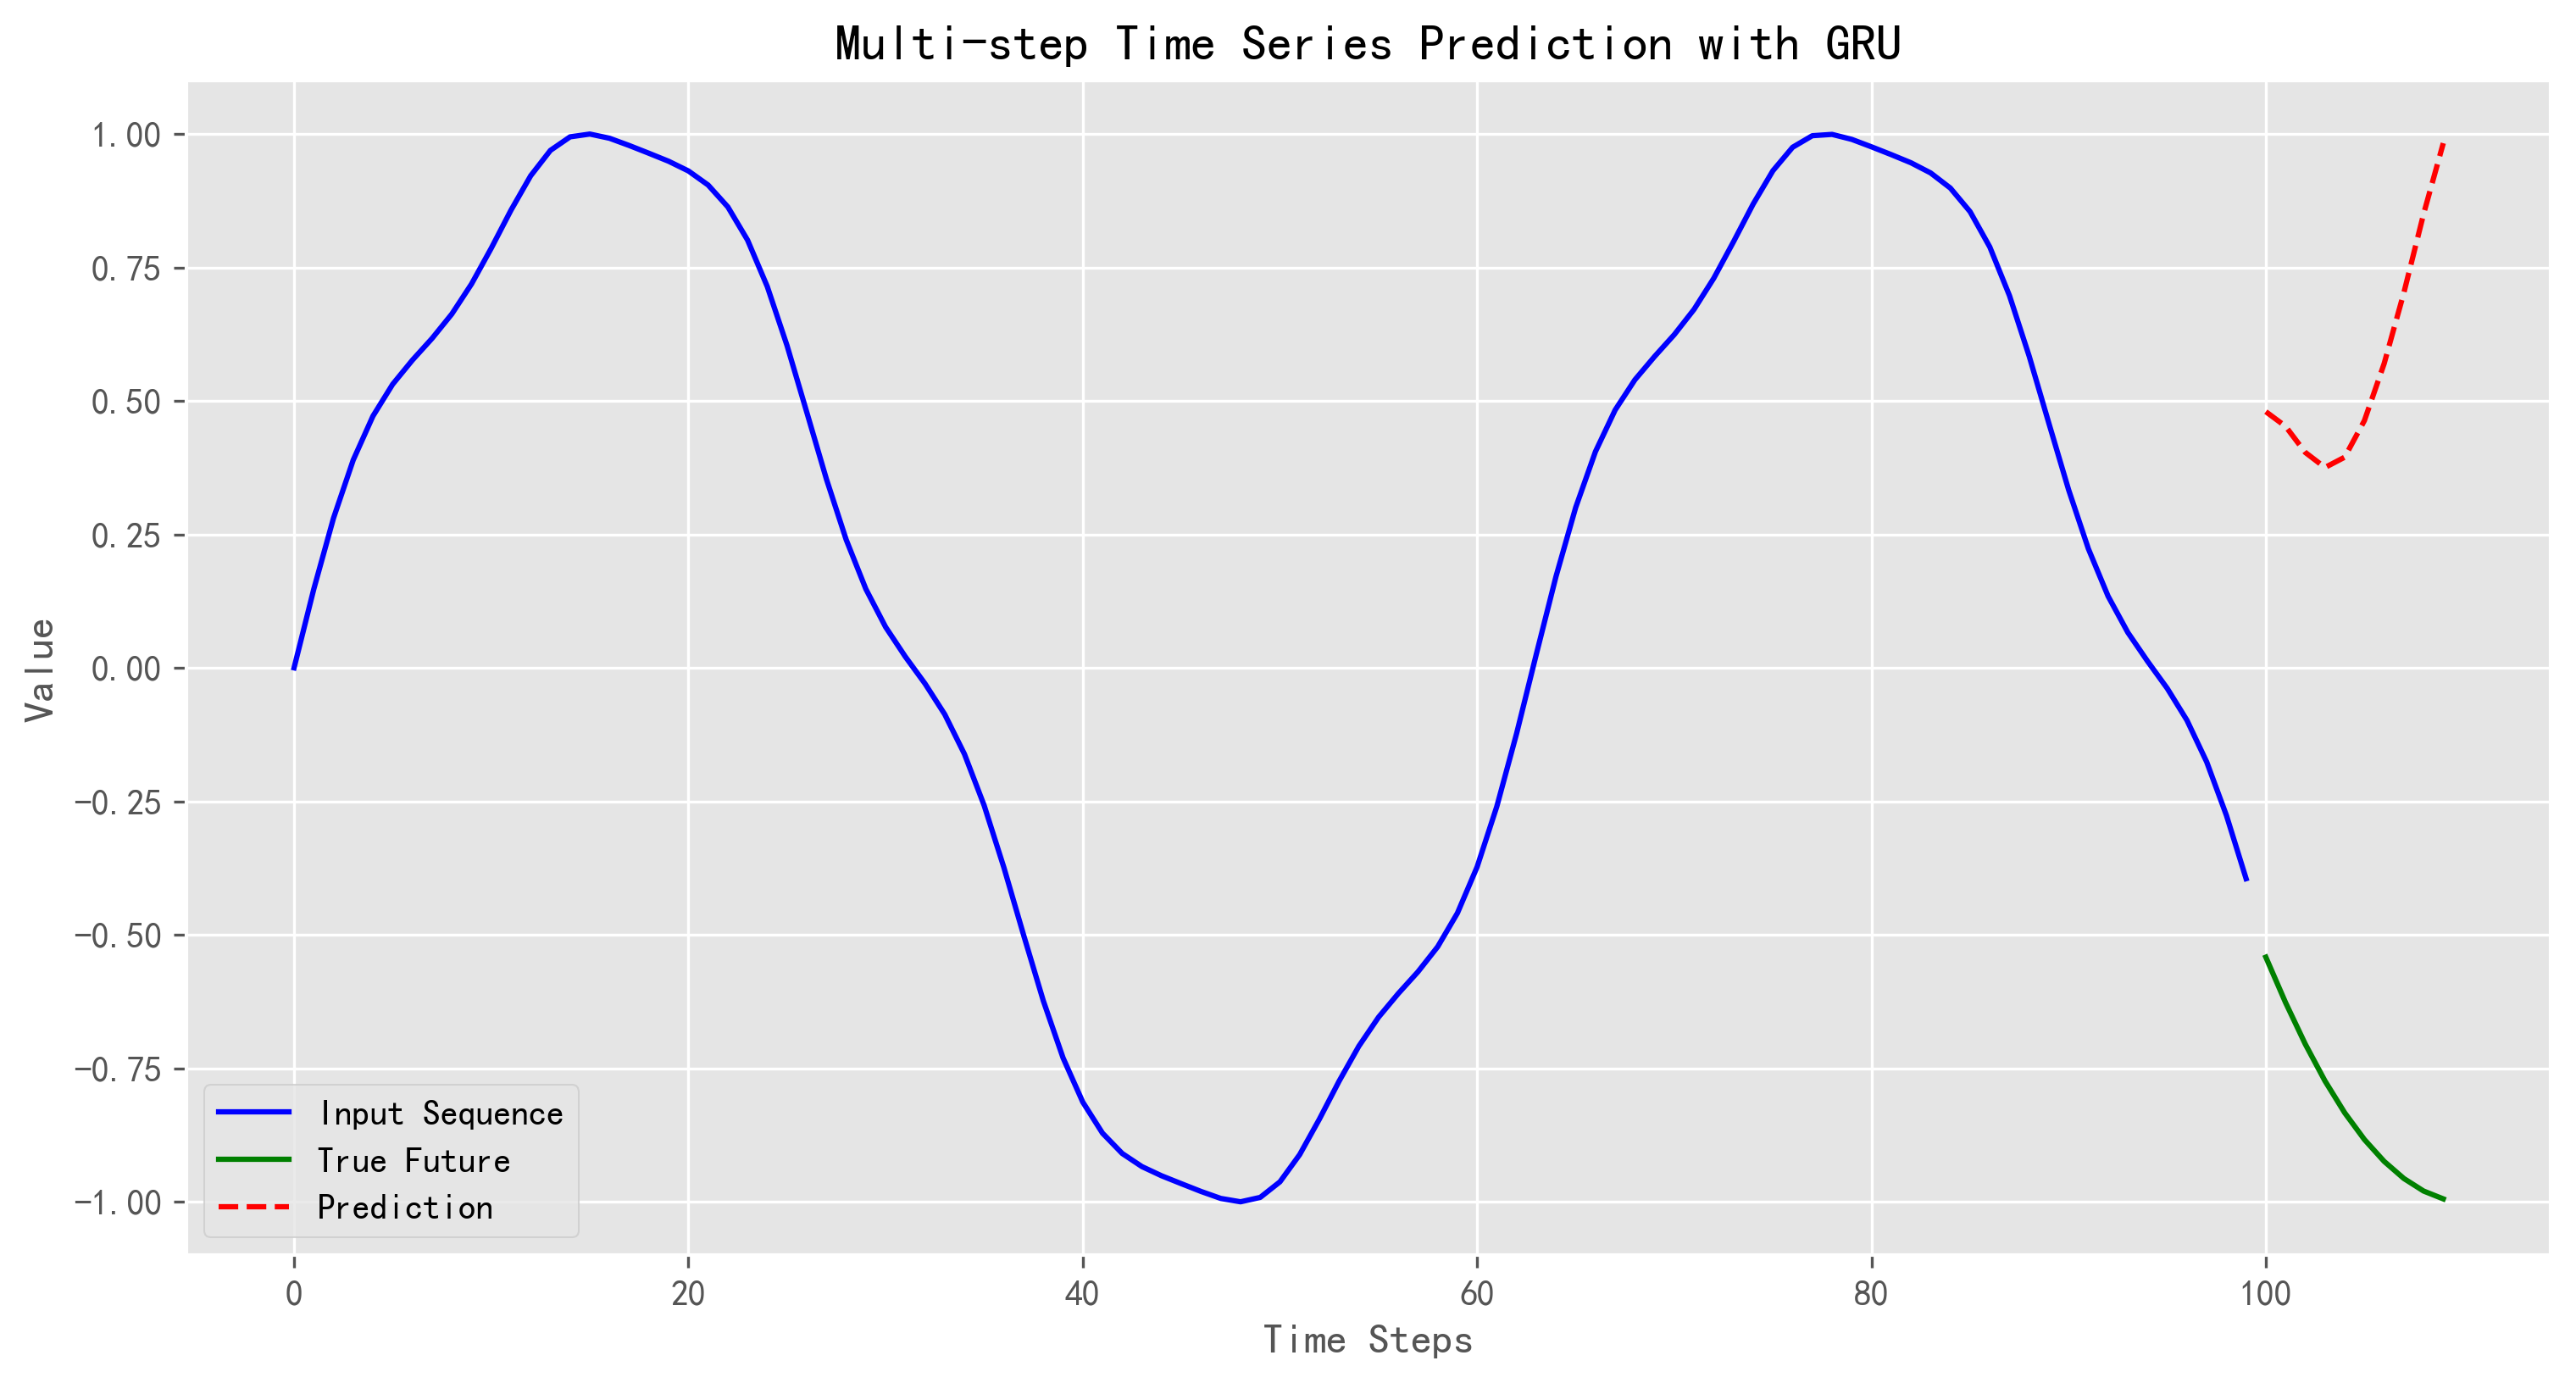

done


In [7]:
import equinox as eqx
import jax
import jax.numpy as jnp
import optax
from typing import List, Tuple
import matplotlib.pyplot as plt

print('使用GRU进行多步时间序列预测')

# 只使用GRU的模型
class GRUModel(eqx.Module):
    input_size: int
    hidden_size: int
    output_size: int
    gru_cell: eqx.nn.GRUCell
    output_layer: eqx.nn.Linear

    def __init__(self, input_size, hidden_size, output_size, key):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        keys = jax.random.split(key, 2)
        self.gru_cell = eqx.nn.GRUCell(input_size, hidden_size, key=keys[0])
        self.output_layer = eqx.nn.Linear(hidden_size, output_size, key=keys[1])

    def __call__(self, xs: jnp.ndarray) -> jnp.ndarray:
        h = jnp.zeros((self.hidden_size,))
        for x in xs:
            h = self.gru_cell(x, h)
        return self.output_layer(h)

    def predict_future(self, xs: jnp.ndarray, future_steps: int) -> jnp.ndarray:
        '''
        实现多步骤预测
        '''
        h = jnp.zeros((self.hidden_size,))
        
        # Process the input sequence
        for x in xs:
            h = self.gru_cell(x, h)
        
        # Predict future steps
        predictions = []
        last_pred = xs[-1]
        for _ in range(future_steps):
            h = self.gru_cell(last_pred, h)
            last_pred = self.output_layer(h)
            predictions.append(last_pred)
        
        return jnp.array(predictions)

# 生成示例数据 (保持不变)
def generate_data(seq_length, n_sequences, future_steps):
    x = jnp.arange(seq_length + future_steps)
    y = jnp.sin(0.1 * x) + 0.1 * jnp.sin(0.5 * x) + 0.05 * jax.random.normal(jax.random.PRNGKey(0), (seq_length + future_steps,))
    
    xs, ys = [], []
    for _ in range(n_sequences):
        start = jax.random.randint(jax.random.PRNGKey(0), (), 0, seq_length - 100)
        xs.append(y[start:start+100])
        ys.append(y[start+100:start+100+future_steps])
    
    return jnp.array(xs), jnp.array(ys)

# 训练函数
@eqx.filter_value_and_grad
def compute_loss(model: GRUModel, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    '''
    比较的是多个预测步的值和真值之间的差
    '''
    pred = jax.vmap(model.predict_future, in_axes=(0, None))(x, y.shape[1])
    return jnp.mean((pred - y) ** 2)

@eqx.filter_jit
def make_step(model: GRUModel, x: jnp.ndarray, y: jnp.ndarray, opt_state, optimizer):
    loss, grads = compute_loss(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

# 主函数
# 修改参数
input_size = 1
hidden_size = 128
output_size = 1
seq_length = 300
future_steps = 10
n_sequences = 1000
batch_size = 64  # 增加批量大小
learning_rate = 1e-3
num_epochs = 1000  # 增加训练轮数

# 生成数据
x_data, y_data = generate_data(seq_length, n_sequences, future_steps)
x_data = x_data.reshape(-1, 100, 1)
y_data = y_data.reshape(-1, future_steps, 1)

# 初始化模型
key = jax.random.PRNGKey(0)
model = GRUModel(input_size, hidden_size, output_size, key)

# 使用更复杂的学习率调度器 # 与单步预测不同...
schedule_fn = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=learning_rate, warmup_steps=100, decay_steps=num_epochs, end_value=1e-5)
optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(learning_rate=schedule_fn))   # 添加梯度裁剪
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

# 训练循环
best_loss = float('inf')
patience = 100
patience_counter = 0

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i in range(0, n_sequences, batch_size):
        x_batch = x_data[i:i+batch_size]
        y_batch = y_data[i:i+batch_size]
        loss, model, opt_state = make_step(model, x_batch, y_batch, opt_state, optimizer)
        epoch_loss += loss

    avg_loss = epoch_loss / (n_sequences // batch_size)

    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if epoch % 50 == 0 or epoch == num_epochs - 1: print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")

    if patience_counter >= patience: # 早停(避免过拟合)
        print(f"Early stopping at epoch {epoch+1}")
        break

# 预测并可视化
test_x = jnp.sin(0.1 * jnp.arange(100) + 0.1 * jnp.sin(0.5 * jnp.arange(100))).reshape(1, 100, 1)
true_future = jnp.sin(0.1 * (jnp.arange(100, 110) + 0.1 * jnp.sin(0.5 * jnp.arange(100, 110))))
prediction = model.predict_future(test_x[0], future_steps)

plt.figure(figsize=(12, 6))
plt.plot(range(100), test_x[0], label='Input Sequence', color='blue')
plt.plot(range(100, 110), true_future, label='True Future', color='green')
plt.plot(range(100, 110), prediction, label='Prediction', color='red', linestyle='--')
plt.legend()
plt.title('Multi-step Time Series Prediction with GRU')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.show()

print('done')

------